In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional, Dot
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/both-5-8-2020.h5','r')
# ['j1_pt', 'j1_eta', 'j1_phi', 'j1_x', 'j1_y', 'j1_z', 'j1_m', 'j1_e', 'j1_DL1r', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_x', 'j2_y', 'j2_z', 'j2_m', 'j2_e', 'j2_DL1r', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_x', 'j3_y', 'j3_z', 'j3_m', 'j3_e', 'j3_DL1r', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_x', 'j4_y', 'j4_z', 'j4_m', 'j4_e', 'j4_DL1r', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_x', 'j5_y', 'j5_z', 'j5_m', 'j5_e', 'j5_DL1r', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_x', 'j6_y', 'j6_z', 'j6_m', 'j6_e', 'j6_DL1r', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_x', 'lep_y', 'lep_z', 'lep_e', 'met_met', 'met_phi']

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']

Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  1000000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart_pt', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'DL1r', 'm':'meanmax', 'x':'null', 'y':'null', 'z':'null', 'e':'null', 'isbtag':'null','met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 4.547473508864641e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)
    
    


In [4]:
# DL1r = totalX_jets[:,:,-1]
# argDL1r = np.argsort(DL1r,axis=-1)
# argDL1r = argDL1r.reshape((argDL1r.shape[0], -1, 1))
# jets_byDL1r = np.take_along_axis(totalX_jets, argDL1r, axis=1)
# totalX_jets = np.concatenate([totalX_jets, jets_byDL1r], axis=1)

length = totalX_jets.shape[0]
perm = np.random.permutation(length)
perm = perm.reshape((perm.shape[0]))

jets_random = totalX_jets[perm]
totalX_jets = jets_random 

In [5]:
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(900000, 6, 6) (900000, 7) (900000, 20)
(100000, 6, 6) (100000, 7) (100000, 20)


In [6]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [7]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [8]:
class SinkhornLayer(Layer):
    def __init__(self, n_iters=21, temperature=0.01, **kwargs):
        self.supports_masking = False
        self.n_iters = n_iters
        self.temperature = K.constant(temperature)
        super(SinkhornLayer, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        input_shape = tf.shape(input_tensor)
        n = K.shape(input_tensor)[1]
        log_alpha = K.reshape(input_tensor, [-1, n, n])
        log_alpha /= self.temperature

        for _ in range(self.n_iters):
            log_alpha -= K.reshape(K.log(K.sum(K.exp(log_alpha), axis=2)), [-1, n, 1])
            log_alpha -= K.reshape(K.log(K.sum(K.exp(log_alpha), axis=1)), [-1, 1, n])
        return tf.reshape(K.exp(log_alpha), self.compute_output_shape(input_shape)) 

    def compute_mask(self, x, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return input_shape

def build_classifier():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(240, activation='relu')(PreDense1)
    Shape0 = Reshape((trainX_jets.shape[1],240/trainX_jets.shape[1]))(PreDense2)
    Predense3 = TimeDistributed(Dense(trainX_jets.shape[1], activation='relu'))(Shape0)
    sinkhorn = SinkhornLayer(n_iters=10, temperature=0.01, name="sinkhorn")(layer_for_combining)
    permute_apply = Dot(axes=[-2, -2])([sinkhorn, jet_input])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=permute_apply)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

In [9]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    other_input = Input(shape=(trainX_other.shape[1]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    flat_jets =  Flatten()(jet_input)
    
    
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(240, activation='relu')(PreDense1)
    Shape0 = Reshape((trainX_jets.shape[1],int(240/trainX_jets.shape[1])))(PreDense2)
    Predense3 = TimeDistributed(Dense(trainX_jets.shape[1], activation='relu'))(Shape0)
    sinkhorn = SinkhornLayer(n_iters=20, temperature=0.1, name="sinkhorn")(Predense3)
    permute_apply = Dot(axes=[-2, -2])([sinkhorn, jet_input])
    
    TDDense13 = TimeDistributed(Dense(128, activation='relu'))(permute_apply)
    TDDense14= TimeDistributed(Dense(128, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(128, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

# model = keras.models.load_model('Jet_Reweight_cartpt.keras')
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [10]:
# Fit model

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}


Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))



history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)


Train on 900000 samples, validate on 100000 samples
Epoch 1/256
900000/900000 [==============================] - 14s 16us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 2/256
900000/900000 [==============================] - 11s 12us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/256
900000/900000 [==============================] - 11s 13us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/256
900000/900000 [==============================] - 11s 12us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 5/256
900000/900000 [==============================] - 11s 12us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 6/256
900000/900000 [==============================] - 11s 12us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 7/256
900000/900000 [==============================] - 11s 12us/sample - loss: 0.007

In [11]:
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

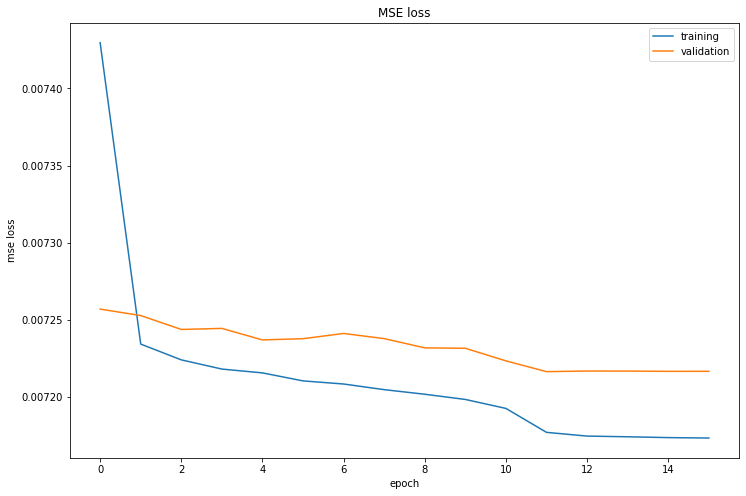

In [12]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [13]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [14]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [15]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.007216735203136259
 
th_ptbox MSE :  0.0041417315
th_px MSE :  0.0052888289
th_py MSE :  0.0055334737
th_eta MSE :  0.0328398279
th_m MSE :  0.0042599947
wh_ptbox MSE :  0.0037815797
wh_px MSE :  0.0046330727
wh_py MSE :  0.0063238904
wh_eta MSE :  0.0374610731
wh_m MSE :  0.0034844911
tl_ptbox MSE :  0.0037832652
tl_px MSE :  0.0043738576
tl_py MSE :  0.0036648926
tl_eta MSE :  0.0076477881
tl_m MSE :  0.0047510812
wl_ptbox MSE :  0.0021395720
wl_px MSE :  0.0013680910
wl_py MSE :  0.0017913801
wl_eta MSE :  0.0038692546
wl_m MSE :  0.0031975579


In [16]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 652.9308639302615
 
th_pt MSE :  3779.6461624207
th_eta MSE :  2.2787968974
th_phi MSE :  1.2508733169
th_m MSE :  35.4596172074
wh_pt MSE :  2782.7799823646
wh_eta MSE :  1.8524628586
wh_phi MSE :  1.7402273170
wh_m MSE :  28.2028204219
tl_pt MSE :  3116.4911898517
tl_eta MSE :  0.6013232665
tl_phi MSE :  0.8417271214
tl_m MSE :  39.4656846375
wl_pt MSE :  611.4157969645
wl_eta MSE :  0.3206930165
wl_phi MSE :  0.2002461520
wl_m MSE :  34.9898007650


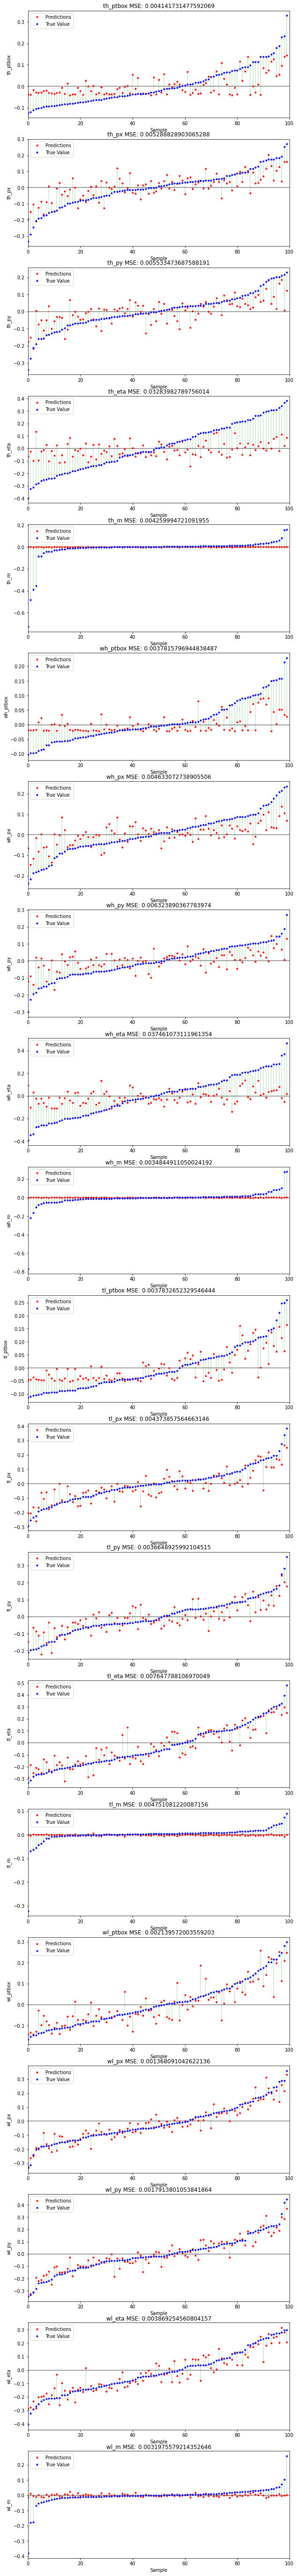

In [17]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

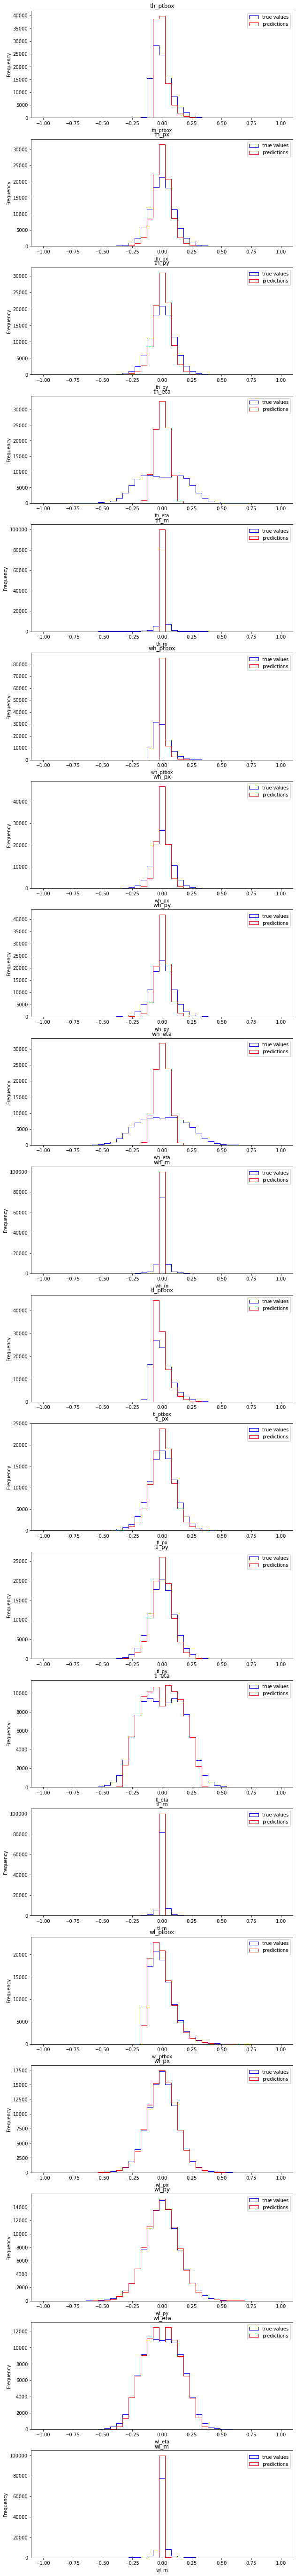

In [18]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

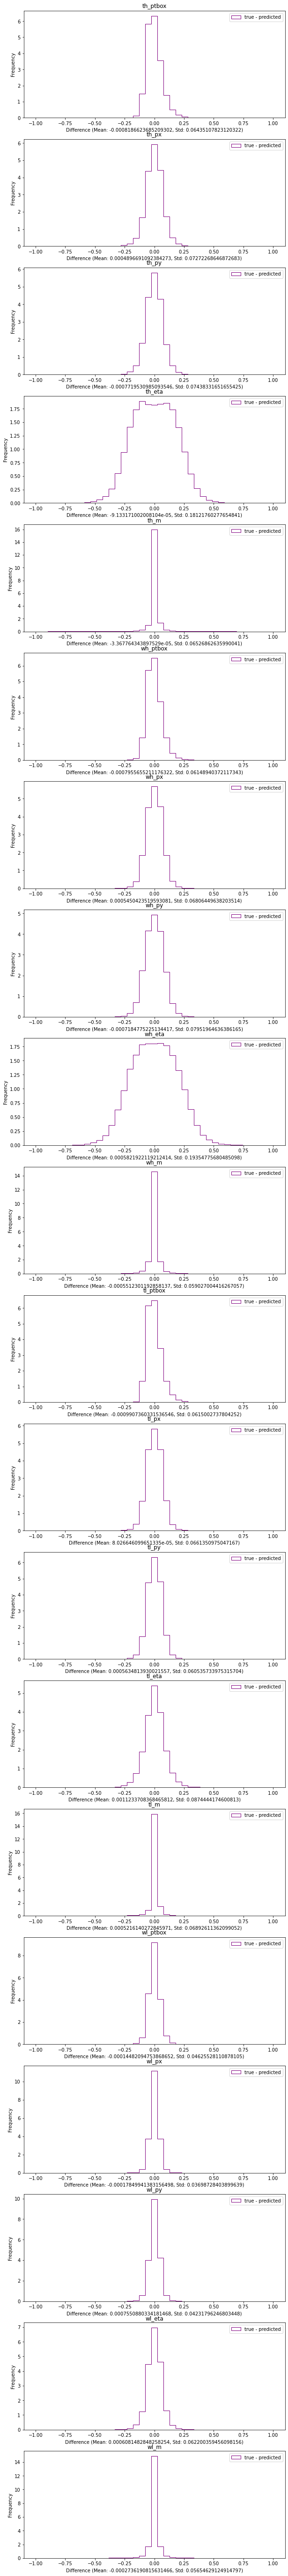

In [19]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

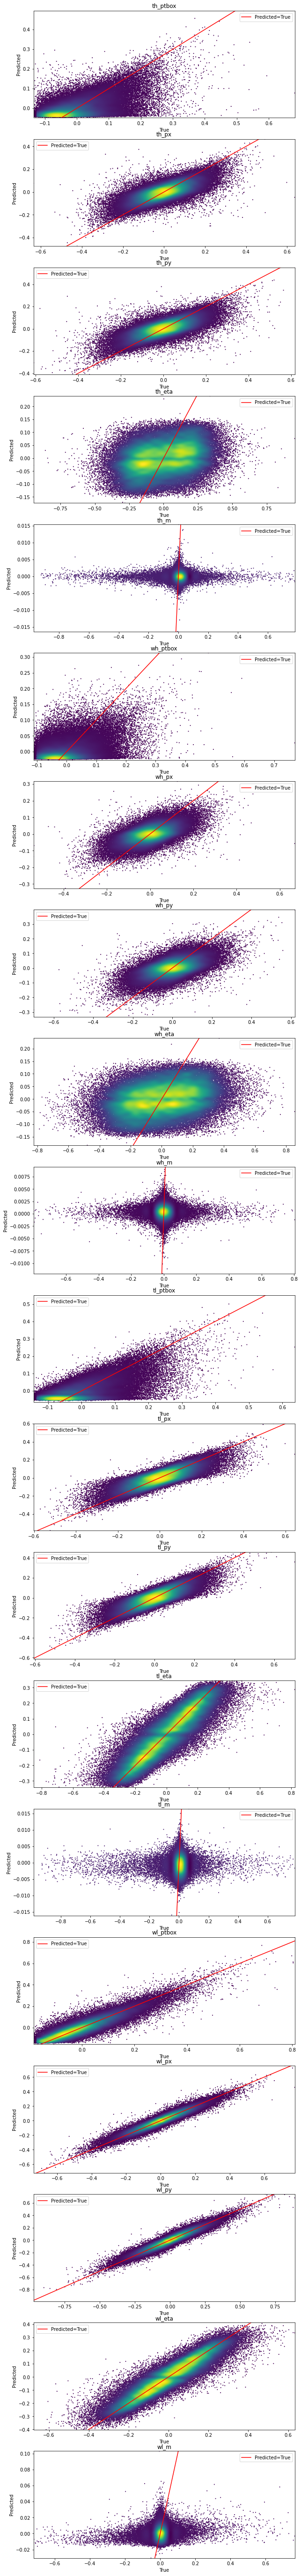

In [20]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [21]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 652.9308639302615
 
th_pt MSE :  3779.6461624207
th_eta MSE :  2.2787968974
th_phi MSE :  1.2508733169
th_m MSE :  35.4596172074
wh_pt MSE :  2782.7799823646
wh_eta MSE :  1.8524628586
wh_phi MSE :  1.7402273170
wh_m MSE :  28.2028204219
tl_pt MSE :  3116.4911898517
tl_eta MSE :  0.6013232665
tl_phi MSE :  0.8417271214
tl_m MSE :  39.4656846375
wl_pt MSE :  611.4157969645
wl_eta MSE :  0.3206930165
wl_phi MSE :  0.2002461520
wl_m MSE :  34.9898007650


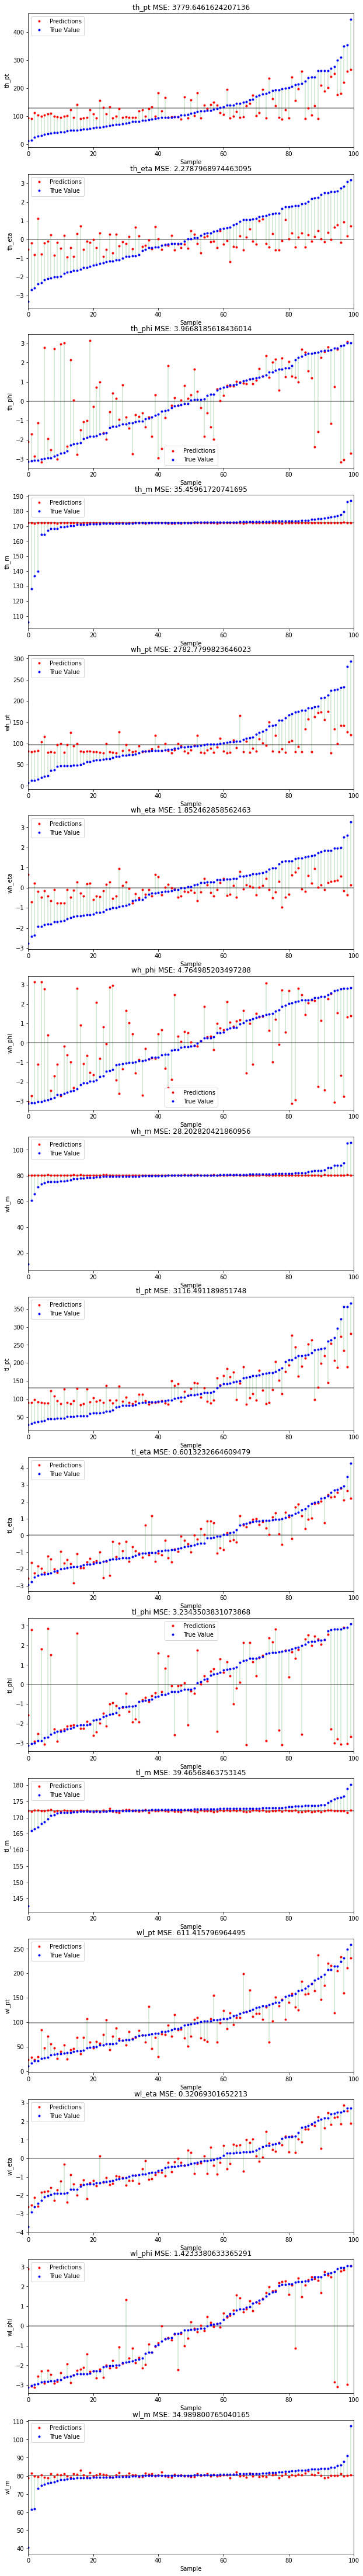

In [22]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

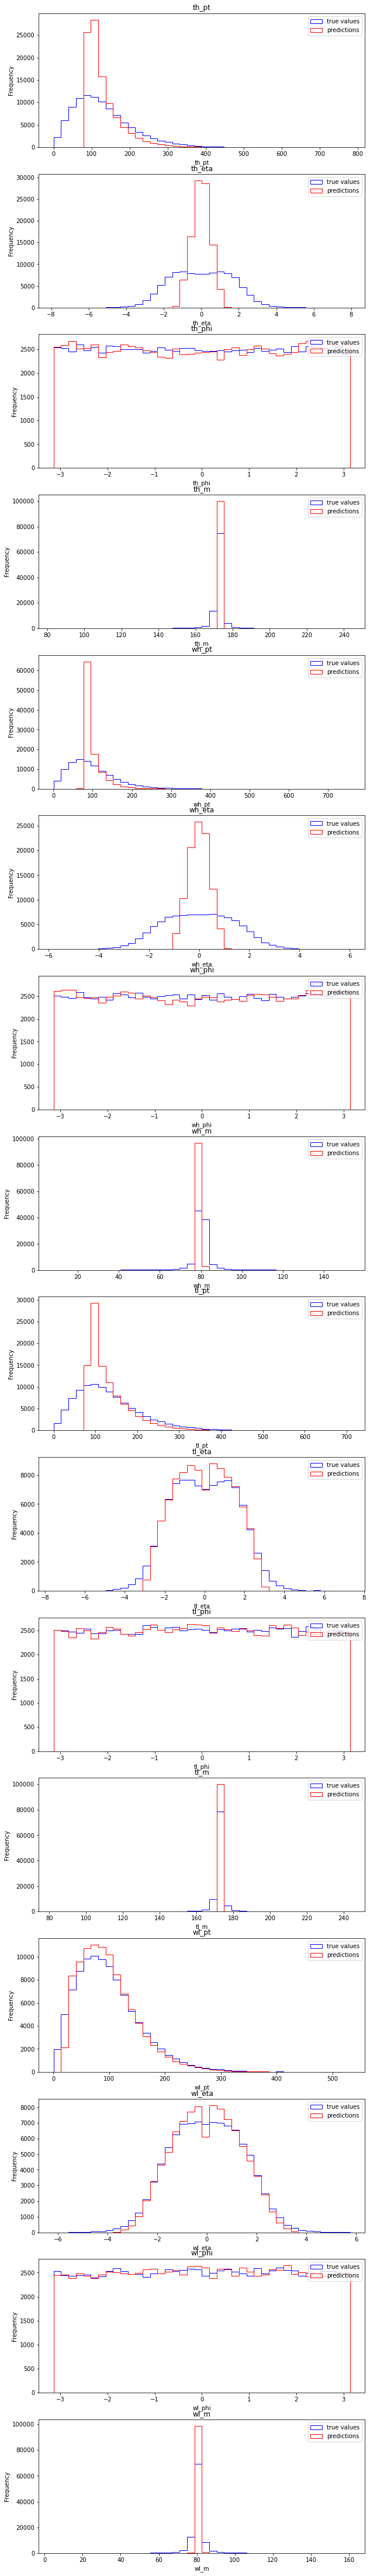

In [23]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

In [ ]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

In [ ]:
# model.save('Jet_Reweight_lr_decay_ex.keras')

# Observables

In [ ]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

In [ ]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

In [ ]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


In [ ]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


In [ ]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

In [ ]:
# model.save('Jet_Reweight_cartpt.keras')

In [ ]:
np.save('aug_9/Jet_Reweight_cartpt_pred', predictions_origscale)
np.save('aug_9/Jet_Reweight_cartpt_true', true_origscale)
truth_observables = [truths[list(truths.keys())[i]].value for i in range(len(list(truths.keys())))]
pred_observables = [preds[list(preds.keys())[i]].value for i in range(len(list(preds.keys())))]
truth_observables = np.stack(truth_observables, axis=1)
truth_observables = truth_observables.reshape((truth_observables.shape[0], -1))
pred_observables = np.stack(pred_observables, axis=1)
pred_observables = pred_observables.reshape((pred_observables.shape[0], -1))

np.save('aug_9/Jet_Reweight_cartpt_pred_observables', pred_observables)
np.save('aug_9/Jet_Reweight_cartpt_true_observables', truth_observables)
print(list(preds.keys()))